In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, romberg
import warnings

In [2]:
#Constants
m_p = 0.938#Proton rest mass in GeV/c2
m_pi0 = 0.1349766#Neutral pion rest mass in GeV/c2

#Conversions
mb_to_cm2 = 1.0e-27 #cm2

In [29]:
#The functions from Kafexhiu (the parametrization paper)

#Equ.8: differential cross section. peak_func is the maximum value/ normalization and spec_func describes the shape of the spectrum 
def diff_gamma_cs(T_p, E_gamma):
    
    cs = peak_func(T_p)*spec_func(T_p, E_gamma) 
    
    return cs

def peak_func(T_p):

    T_th = 0.28 #GeV
    T_cut = 1.0 #GeV
    
    s = 2.0*m_p*(T_p + 2.0*m_p)
    
    gamma_CM = (T_p + 2.0*m_p)/np.sqrt(s)
    E_pi_CM = (s-4.0*m_p*m_p + m_pi0*m_pi0)/(2.0*np.sqrt(s))
    P_pi_CM = np.sqrt((E_pi_CM*E_pi_CM)-(m_pi0*m_pi0))
    beta_CM = np.sqrt(1.0-((1.0/gamma_CM)**2.0))
    
    E_pi_max = gamma_CM*(E_pi_CM+P_pi_CM*beta_CM)
    b_0 = 5.9
    b_1 = b_1_fit(T_p)
    b_2 = b_2_fit(T_p)
    b_3 = b_3_fit(T_p)
    theta_p = T_p/m_p
    
    if (T_p>=T_th):
        if (T_p<T_cut):
            func_val = b_0*cs_pp(T_p)/E_pi_max
            #print("a", T_p, func_val, cs_pp(T_p))
        else:
            func_val = b_1*((theta_p)**(-1.0*b_2))*np.exp(b_3*((np.log(theta_p))**2.0))*cs_pp(T_p)/m_p
            #print("b", T_p, func_val, b_1, b_2, b_3, theta_p, cs_pp(T_p))
    else:
        func_val = 0.0
        #print("c", T_p, func_val, cs_pp(T_p))
    
    return func_val


def b_1_fit(T_p):
    
    if (T_p<1.0):
        b_1 = 0.0
    if (1.0<=T_p<5.0):
        b_1 = 9.53
    if (5.0<=T_p<50.0):
        b_1 = 9.13
    if (50.0<=T_p):
        b_1 = 9.06
    
    return b_1

def b_2_fit(T_p):
    
    if (T_p<1.0):
        b_2 = 0.0
    if (1.0<=T_p<5.0):
        b_2 = 0.52
    if (5.0<=T_p<50.0):
        b_2 = 0.35
    if (50.0<=T_p):
        b_2 = 0.3795
    
    return b_2

def b_3_fit(T_p):
    
    if (T_p<1.0):
        b_3 = 0.0
    if (1.0<=T_p<5.0):
        b_3 = 0.054
    if (5.0<=T_p<50.0):
        b_3 = 0.0097
    if (50.0<=T_p):
        b_3 = 0.01105
    
    return b_3

#equ.4 relativistic Breit-Wigner distribution
def fbw_func(cm_en):
    
    Mres = 1.1883 #GeV
    Gamma_res = 0.2264 #GeV
    gval = np.sqrt(Mres*Mres*(Mres*Mres+Gamma_res*Gamma_res))
    Kconst = np.sqrt(8.0)*Mres*Gamma_res*gval/(np.pi*np.sqrt((Mres*Mres)+gval))
    fbw_val = m_p*Kconst/(((((cm_en-m_p)**2.0)-Mres**2.0)**2.0) + (Mres**2.0)*(Gamma_res**2.0))
    
    return fbw_val

def cs1pi(T_p):
    
    s = 2.0*m_p*(T_p + 2.0*m_p)
    eta = np.sqrt(((s-(m_pi0*m_pi0)-(4.0*m_p*m_p))**2.0)-(16.0*m_pi0*m_pi0*m_p*m_p))/(2.0*m_pi0*np.sqrt(s))
    sig0 = 0.00766 #mbarn
    cs = sig0*(eta**(1.95))*(1.0+eta+(eta**5.0))*((fbw_func(np.sqrt(s)))**(1.86))
    
    #print("CS1", T_p, s, eta, sig0, fbw_func(np.sqrt(s)), cs)
    
    return cs
    
def cs2pi(T_p):
    
    if (T_p>0.56):
        cs = 5.7/(1.0+np.exp(-9.3*(T_p-1.4)))
    else:
        cs = 0.0
        
    return cs

def cs_pp(T_p):
    
    #Inclusive cross section
    T_th = 0.28 #GeV
    
    if (T_p<T_th):
        cross_sec = 0.0
        #print("a", T_p, cross_sec)
    else:
        if (T_p<2.0):
            cross_sec = cs1pi(T_p)+cs2pi(T_p)
            #print("b", T_p, cross_sec, cs1pi(T_p), cs2pi(T_p))
        else:
            cross_sec = sigma_inel(T_p)*mutiplicity_pion(T_p)
            #print("c", T_p, cross_sec, sigma_inel(T_p), mutiplicity_pion(T_p))
    
    return cross_sec


def sigma_inel(T_p):
    
    T_th = 0.28
    
    cross_sec = (30.7-0.96*np.log(T_p/T_th) + 0.18*(np.log(T_p/T_th))**2.0)*(1.0-(T_th/T_p)**1.9)**3.0
    
    return cross_sec


def mutiplicity_pion(T_p):
    
    T_th = 0.28
    
    Qp = (T_p - T_th)/m_p
    xi_p = (T_p - 3.0)/m_p
    
    if (T_p<50.0):
        a_1 = 0.728
        a_2 = 0.596
        a_3 = 0.491
        a_4 = 0.2503
        a_5 = 0.117
    else:
        if (T_p<100.0):
            a_1 = 0.652
            a_2 = 0.0016
            a_3 = 0.488
            a_4 = 0.1928
            a_5 = 0.483
        else:
            a_1 = 5.436
            a_2 = 0.254
            a_3 = 0.072
            a_4 = 0.075
            a_5 = 0.116
    
    
    if (T_p<5.0):
        multi_av = -0.006 + 0.237*Qp - 0.023*Qp*Qp
    else:
        multi_av = a_1*(xi_p**a_4)*(1.0+np.exp(-a_2*(xi_p**a_5)))*(1.0-np.exp(-a_3*(xi_p**(1.0/4.0))))
    
    return multi_av

def a1func(T_p):
    
    if (T_p<20.0):
        a1 = 1.0
    else:
        a1 = 0.5
    
    return a1


def a2func(T_p):
    
    T_th = 0.28
    
    if (T_p>T_th):
        if (T_p<1.0):     
            a2 = kappa_func(T_p)
        else:
            if (T_p<4.0):
                a2 = mu_func(T_p) + 2.45
            else:
                if (T_p<20.0):
                    a2 = (3.0/2.0)*mu_func(T_p) + 4.95
                else:
                    if (T_p<100.0):
                        a2 = 4.2
                    else:
                        a2 = 4.9
    else:
        a2 = 0.0
    
    return a2


def a3func(T_p):
    
    if (T_p<1.0):
        a3 = 0.0
    else:
        if (T_p<4.0):
            a3 = mu_func(T_p)+1.45
        else:
            if (T_p<20.0):
                a3 = mu_func(T_p) + 1.50
            else:
                a3 = 1.0
    return a3


def kappa_func(T_p):
    
    theta_p = T_p/m_p
    kval = 3.29-(1.0/5.0)*((theta_p)**(-3.0/2.0))

    return kval


def mu_func(T_p):
    #Doesn't matter if the T_p condition is here or not
    #This only gets called for T_p>1 anyway...
    
    if (T_p>1.0):
        qp = (T_p-1.0)/m_p
        muval = (5.0/4.0)*(qp**(5.0/4.0))*np.exp(-(5.0/4.0)*qp)
    else:
        muval = 0.0
        
    return muval


def lambda_func(T_p):
    
    if (T_p>1.0):
        lval = 3.0
    else:
        lval = 1.0
    
    return lval


def spec_func(T_p, E_gamma):
    
    s = 2.0*m_p*(T_p + 2.0*m_p)
    
    gamma_CM = (T_p + 2.0*m_p)/np.sqrt(s)
    E_pi_CM = (s-4.0*m_p*m_p + m_pi0*m_pi0)/(2.0*np.sqrt(s))
    P_pi_CM = np.sqrt((E_pi_CM*E_pi_CM)-(m_pi0*m_pi0))
    beta_CM = np.sqrt(1.0-((1.0/gamma_CM)**2.0))
    
    E_pi_max_lab = gamma_CM*(E_pi_CM + P_pi_CM*beta_CM)
    
    gamma_pi0_lab = E_pi_max_lab/m_pi0
    beta_pi0_lab = np.sqrt(1.0-((1.0/gamma_pi0_lab)**2.0))
    
    E_gamma_max = (m_pi0/2.0)*gamma_pi0_lab*(1.0+beta_pi0_lab)
    
    Y = E_gamma + (m_pi0*m_pi0)/(4.0*E_gamma)
    Ymax = E_gamma_max + (m_pi0*m_pi0)/(4.0*E_gamma_max)
    
    X = (Y-m_pi0)/(Ymax - m_pi0)
    CV = lambda_func(T_p)*m_pi0/Ymax
    if ((X**a1func(T_p))>1.0):
        func_val = 0.0
    else:
        func_val = (((1.0-(X**a1func(T_p)))**(a2func(T_p)))/((1.0+(X/CV))**(a3func(T_p))))
    
    #print(T_p, E_gamma, X)
    
    return func_val

#Numerical integrator
#(note needs to be loglog, otherwise insufficient resolution at high energies)

def trapz_loglog(y, x, axis=-1, intervals=False):
    """
    Integrate along the given axis using the composite trapezoidal rule in
    loglog space.

    Integrate `y` (`x`) along given axis in loglog space.

    Parameters
    ----------
    y : array_like
        Input array to integrate.
    x : array_like, optional
        Independent variable to integrate over.
    axis : int, optional
        Specify the axis.

    Returns
    -------
    trapz : float
        Definite integral as approximated by trapezoidal rule in loglog space.
    """
    try:
        y_unit = y.unit
        y = y.value
    except AttributeError:
        y_unit = 1.0
    try:
        x_unit = x.unit
        x = x.value
    except AttributeError:
        x_unit = 1.0

    y = np.asanyarray(y)
    x = np.asanyarray(x)

    slice1 = [slice(None)] * y.ndim
    slice2 = [slice(None)] * y.ndim
    slice1[axis] = slice(None, -1)
    slice2[axis] = slice(1, None)

    slice1 = tuple(slice1)
    slice2 = tuple(slice2)
    
    #print("B VAL", y, x, slice1, slice2, y.ndim)

    if x.ndim == 1:
        shape = [1] * y.ndim
        shape[axis] = x.shape[0]
        x = x.reshape(shape)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Compute the power law indices in each integration bin
        b = np.log10(y[slice2] / y[slice1]) / np.log10(x[slice2] / x[slice1])

        # if local powerlaw index is -1, use \int 1/x = log(x); otherwise use
        # normal powerlaw integration
        trapzs = np.where(
            np.abs(b + 1.0) > 1e-10,
            (
                y[slice1]
                * (x[slice2] * (x[slice2] / x[slice1]) ** b - x[slice1])
            )
            / (b + 1),
            x[slice1] * y[slice1] * np.log(x[slice2] / x[slice1]),
        )

    tozero = (y[slice1] == 0.0) + (y[slice2] == 0.0) + (x[slice1] == x[slice2])
    trapzs[tozero] = 0.0
    
    #print("IN INT", x_unit, y_unit, trapzs)

    if intervals:
        return trapzs * x_unit * y_unit

    ret = np.add.reduce(trapzs, axis) * x_unit * y_unit

    return ret


#Possible forms of proton spectral index

def proton_spec(n0, gamma_p, spec_ind):
    
    gamma_p_ref = 1.066 #I.e. 1 GeV protons lorentz factor
    n_prot = n0*(gamma_p/gamma_p_ref)**(spec_ind)
    
    return n_prot


def exp_spec(n0, gamma_p, spec_ind):
    
    Ep = gamma_p*m_p#(m_p + Tp)
    #return (1.4*1e-9*(2+p)*E_min**(p)*((Ep/E_min)**(p)))/(E_max**(2+p) - E_min**(2+p))
    A = 0.2
    n_prot2 = n0*(A/(Ep**2))*np.exp(-Ep/10.0**(4.0))
    
    return n_prot2
    
#Function to set the proton spectral normalization
    
def proton_normalisation(ucr, spec_ind, Tpmin, Tpmax):

    GeV_to_eV = 1000000000.
    MeV_to_GeV = 0.001
    
    e_min = (Tpmin+m_p)*GeV_to_eV
    e_max = (Tpmax+m_p)*GeV_to_eV

    #proton_norm = (GeV_to_eV/MeV_to_GeV)*ucr*(2.0+spec_ind)*((e_min)**(spec_ind))/(((e_max)**(2.0+spec_ind))-((e_min)**(2.0+spec_ind)))
    proton_norm = (GeV_to_eV)*ucr*(2.0+spec_ind)*((e_min)**(spec_ind))/(((e_max)**(2.0+spec_ind))-((e_min)**(2.0+spec_ind)))

    return proton_norm


#Differential gamma-ray emissivity (to be integrated over)

def gamma_ray_emissivity(T_p, E_gamma, Tpmin, Tpmax):
    
    ucr = 1.4 #eV/cm3
    spec_ind = -2.2
    n0 = proton_normalisation(ucr, spec_ind, Tpmin, Tpmax)/(4.0*np.pi) #Proton spectrum normalisation
    
    gamma_p = (T_p/m_p)+1.0
    diff_emiss = diff_gamma_cs(T_p, E_gamma)*exp_spec(n0, gamma_p, spec_ind)
    #proton_spec(n0, gamma_p, spec_ind)
    
    return diff_emiss

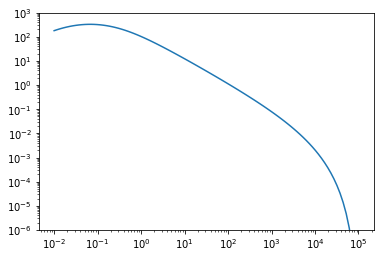

In [30]:
E_gamma_vals = np.logspace(-2, 5, 100)
spec_outs = np.ones_like(E_gamma_vals)*0.01
T_p = 1e5
for i in np.arange(len(E_gamma_vals)):
    E_gamma = E_gamma_vals[i]
    spec_outs[i] = diff_gamma_cs(T_p, E_gamma)

#plt.xlim([0.02, 0.2])
plt.ylim([0.000001, 1000])
plt.loglog(E_gamma_vals, spec_outs)
plt.show()

In [31]:
def gamma_ray_spec_emiss(E_gamma):
    
    Tpmin = 0.28#np.log(0.28)
    Tpmax = 50000000.0#np.log(50000000.0)#np.inf#np.log(5000.0)#np.log(50000000.0)
    
    #evals_ints = np.ones(num_divs)*0.01
    
    tvals = np.logspace(np.log10(Tpmin), np.log10(Tpmax), 100)
    yvals = np.ones_like(tvals)*0.01

    for i in np.arange(len(tvals)):
        tval = tvals[i]
        yval = gamma_ray_emissivity(tval, E_gamma, Tpmin, Tpmax)
        #print(tval, yval)
        yvals[i] = yval
    #eval_int, b = quad(gamma_ray_emissivity, Tpmin, Tpmax, args=(E_gamma, Tpmin, Tpmax))
    eval_int = trapz_loglog(yvals, tvals)
        
    return eval_int

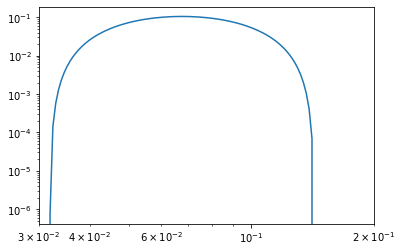

In [32]:
E_gamma_vals = np.logspace(-2, 5, 1000)
spec_outs = np.ones_like(E_gamma_vals)*0.01
T_p = 0.3
Tpmin = 0.28#np.log(0.28)
Tpmax = 50000000.0#np.log(50000000.0)#np.inf#np.log(5000.0)#np.log(50000000.0)
for i in np.arange(len(E_gamma_vals)):
    E_gamma = E_gamma_vals[i]
    spec_outs[i] = diff_gamma_cs(T_p, E_gamma)#, Tpmin, Tpmax)

plt.xlim([0.03, 0.2])
#plt.ylim([0.000001, 1000])
plt.loglog(E_gamma_vals, spec_outs)
plt.show()

In [33]:
E_gamma_vals = np.logspace(-2.0, 5.0, 100)
spec_outs = np.ones_like(E_gamma_vals)*0.01

ngas = 10.0 #cm^-3
clight = 3.0e10 #cm/s
normvals = 4.0*np.pi*clight#*ngas
MeV_to_GeV = 0.001


for i in np.arange(len(E_gamma_vals)):
    E_gamma = E_gamma_vals[i]
    #spec_outs[i] = normvals*(E_gamma/MeV_to_GeV)*(E_gamma/MeV_to_GeV)*gamma_ray_spec_emiss(E_gamma/MeV_to_GeV)
    spec_outs[i] = normvals*gamma_ray_spec_emiss(E_gamma)#/MeV_to_GeV)
    #print(spec_outs[i])


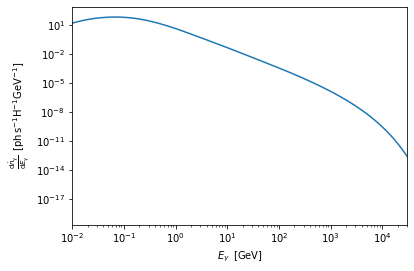

In [34]:
plt.loglog(E_gamma_vals, spec_outs)
plt.ylabel(r'$\frac{{\rm d}\dot{n}_{\gamma}}{{\rm d}E_{\gamma}} \; \; [{\rm ph}\;\!{\rm s}^{-1} {\rm H}^{-1} {\rm GeV}^{-1}]$')
plt.xlabel(r'$E_{\gamma}\; \; [{\rm GeV}]$')
#plt.xlim([1e2, 3e4])
#plt.ylim([1e-25, 1e-23])
plt.xlim([0.01, 30000])
plt.show()

In [35]:
#Reads data file to compare with Kafexhiu's plot

import pandas as pd

raw_data = pd.read_excel("kaf_data.xlsx")

E_gamma_points_kaf = raw_data['Evals']
kafex_points = raw_data['E2FE']

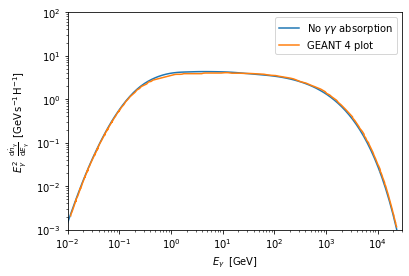

In [36]:
plt.loglog(E_gamma_vals, E_gamma_vals*E_gamma_vals*spec_outs, label=r'No $\gamma\gamma$ absorption')
plt.loglog(E_gamma_points_kaf, kafex_points, label=r'GEANT 4 plot')
plt.ylabel(r'$E_{\gamma}^2\;\;\frac{{\rm d}\dot{n}_{\gamma}}{{\rm d}E_{\gamma}} \; \; [{\rm GeV}\;\!{\rm s}^{-1}\;\!{\rm H}^{-1}]$')# {\rm sr}^{-1}]$')
plt.xlabel(r'$E_{\gamma}\; \; [{\rm GeV}]$')
plt.xlim([0.01, 30000])
plt.ylim([0.001,100])
plt.legend()
plt.show()